# Sobol indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Gaussian Framework

In [2]:
from shapley.tests import AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
dim = 3
beta = [1., 1., 1.]
model = AdditiveGaussian(dim=dim, beta=beta)

theta = [-0.5, 0.2, -0.7]
model.copula_parameters = theta
true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
true_indices = {'full': true_full_indices,
                'ind': true_ind_indices}

### Monte-Carlo estimation using true model

In [3]:
from shapley import SobolIndices

sobol = SobolIndices(model.input_distribution)

In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 500
sobol.build_uncorr_sample(model=model, n_sample=n_sample)

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 42.9 ms


In [5]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
sobol_results = {}

n_boot = 500
estimator = 'sobolmara'

for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    results.true_first_indices = true_indices[indice_type]
    results.true_total_indices = true_indices[indice_type]
    sobol_results[indice_type] = results

CPU times: user 36 ms, sys: 44 ms, total: 80 ms
Wall time: 80.7 ms


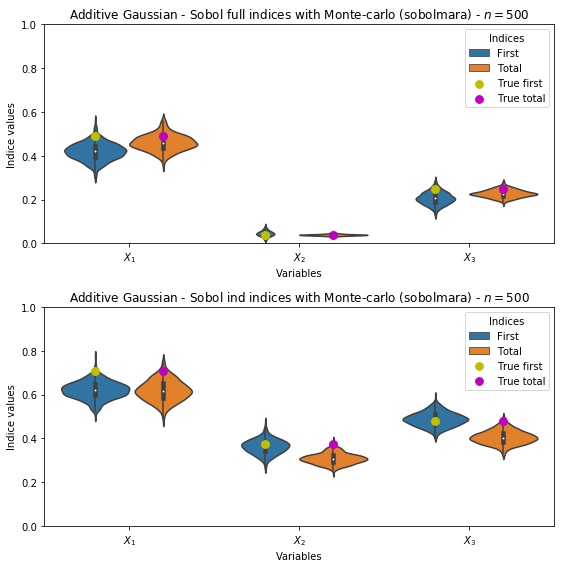

In [6]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_results[indice_type], ax=ax)
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [7]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 15
sampling = 'lhs'
library = 'sklearn'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [8]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling_type='uniform')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.891507784062


In [9]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_realization = 500
sobol.build_uncorr_sample(model=model_gp, n_sample=n_sample, n_realization=n_realization)

CPU times: user 1min 44s, sys: 2.23 s, total: 1min 46s
Wall time: 14.2 s


In [10]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

sobol_gp_results = {}
for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    results.true_first_indices = true_indices[indice_type]
    results.true_total_indices = true_indices[indice_type]
    sobol_gp_results[indice_type] = results

CPU times: user 13.4 s, sys: 13.4 s, total: 26.7 s
Wall time: 26 s


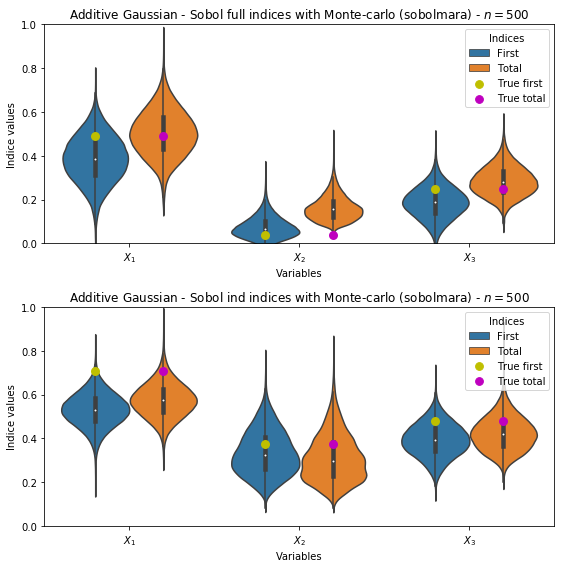

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_gp_results[indice_type], ax=ax)
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

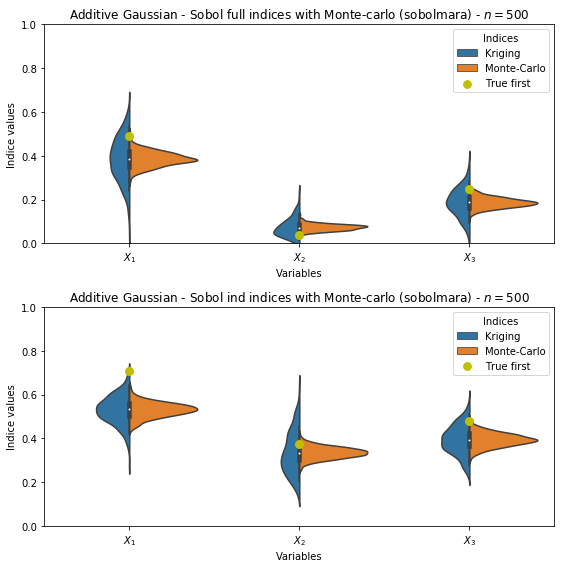

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_gp_results[indice_type], ax=ax, indice='first')
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [13]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling)
model_rf.build(n_realization)

In [14]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling_type='uniform')
print('Q2-score by cross-validation:', q2_score_cv_rf)

Q2-score by cross-validation: 0.652981808354


In [15]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
sobol.build_uncorr_sample(model_rf, n_sample=n_sample, n_realization=n_realization)

CPU times: user 368 ms, sys: 4 ms, total: 372 ms
Wall time: 360 ms


In [16]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

sobol_rf_results = {}
for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    results.true_first_indices = true_indices[indice_type]
    results.true_total_indices = true_indices[indice_type]
    sobol_rf_results[indice_type] = results

CPU times: user 14.1 s, sys: 15.1 s, total: 29.2 s
Wall time: 29.4 s


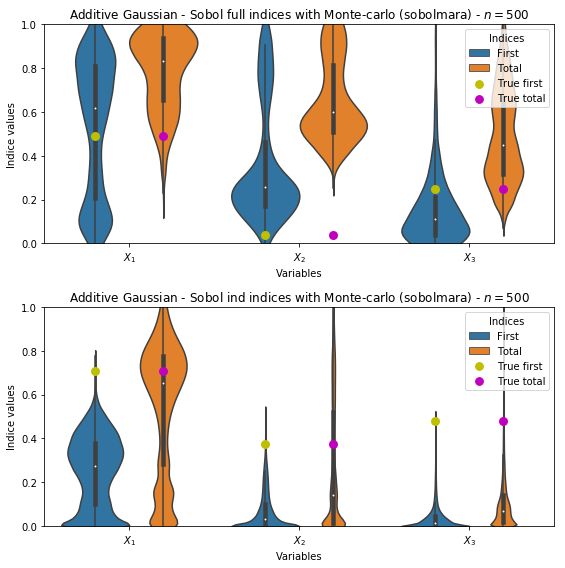

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_rf_results[indice_type], ax=ax)
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()

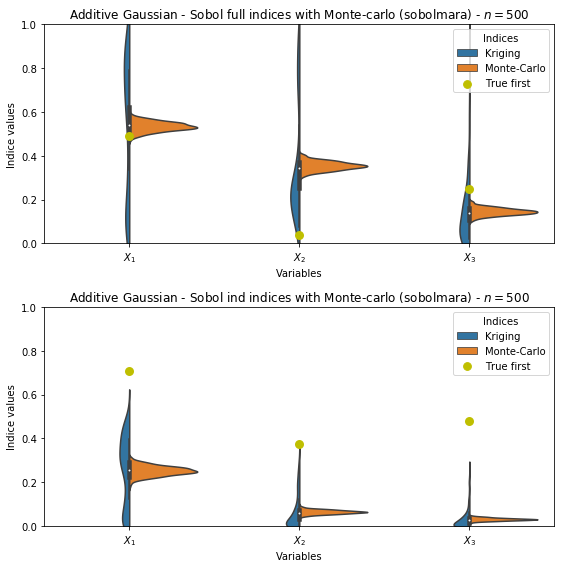

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for i, indice_type in enumerate(['full', 'ind']):
    ax = axes[i]
    plot_sensitivity_results(sobol_rf_results[indice_type], ax=ax, indice='first')
    ax.set_title("%s - Sobol %s indices with Monte-carlo (%s) - $n=%d$" % (model.name, indice_type, estimator, n_sample))
    ax.set_ylim(ylim)
fig.tight_layout()